In [1]:
from pyvacy.analysis import epsilon
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams.update({'font.size': 15})

/Users/comfortablynumb/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def ternary_search(f, left, right, iterations):
    """Performs a search over a closed domain [left, right] for the value which minimizes f."""
    for i in range(iterations):
        left_third = left + (right - left) / 3
        right_third = right - (right - left) / 3
        if f(left_third) < f(right_third):
            right = right_third
        else:
            left = left_third
    return (left + right) / 2

In [3]:
def d(gamma, d1, d2):
    return (np.sqrt(2)/ gamma) * np.sqrt(d1) * np.log2(1/d2) + (d2)

In [4]:
def compute_d1(target_delta, gamma):
    return ternary_search(lambda d1: abs(target_delta-d(gamma, d1, 1*1e-20)), 1e-30, 1e-5, 100)

In [5]:
def compute_epsilon(nm, l, iters, target_delta, d_size, g):
    lt_d1 = compute_d1(target_delta, g)
    model_eps = epsilon(d_size, l, nm, iters, lt_d1)
    return 3*model_eps + 3*np.sqrt(2*lt_d1)

In [6]:
def compute_d1_d2(target_delta, gamma, d2):
    return ternary_search(lambda d1: abs(target_delta-d(gamma, d1, 1*d2)), 1e-30, 1e-5, 100)
def compute_epsilon_d2(nm, l, iters, target_delta, d_size, g, d2):
    lt_d1 = compute_d1_d2(target_delta, g, d2)
    model_eps = epsilon(d_size, l, nm, iters, lt_d1)
    return 3*model_eps + 3*np.sqrt(2*lt_d1)

Figure 1 : LT vs MA

In [7]:
noise =  4
iterations = 10000
batch_size = 250
sizes = np.append([5000],np.arange(50000, 1000000, 100000))

In [8]:
df = []
factor = []
for s in sizes:
    ds = []
    target_delta = 10**-(len(str(s))+1)
    ds.append(compute_epsilon(noise, batch_size,iterations, target_delta, s, 1))
    ds.append(epsilon(s, batch_size, noise, iterations, target_delta))
    factor.append(round(ds[0]/ds[1],2))
    df.append(ds)

In [9]:
df = pd.DataFrame(df, index=sizes, columns=['LT', 'MA'])
df['size'] = sizes
df = df.melt(id_vars='size')
df = df.rename({'size':'Dataset Size', 'variable':'method', 'value':'Final Epsilon'}, axis=1)

<ipython-input-10-ae6acc15651e>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 200)


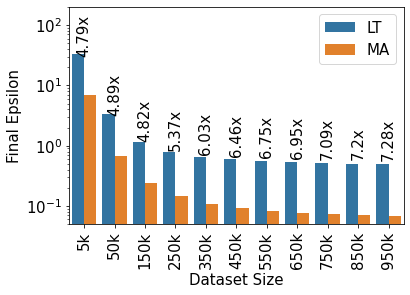

In [10]:
g = sns.barplot(data= df, x='Dataset Size', y='Final Epsilon', hue='method')
ticklabels = ['5k', '50k', '150k', '250k', '350k', '450k', '550k', '650k', '750k', '850k', '950k']
# g.set_xticks(sizes)
g.set_xticklabels(ticklabels, rotation=90, fontsize=15)
for index, value in df.iterrows():
    if(value.method=='LT'):
        g.text(index,value['Final Epsilon']+0.15, f'{factor[index]}x', color='black', ha="center", fontsize=15, rotation=90)
g.set(yscale='log')
plt.legend(fontsize=15)
plt.ylim(0, 200)
plt.savefig('Plots/LTvsMA/blowup.png', bbox_inches="tight",dpi=300)

Figure 1 : Varying Gamma

In [15]:
noise =  4
iterations = 10000
batch_size = 250
gammas = [1e-3,1e-2,1e-1, 1]
sizes = np.append([5000],np.arange(50000, 1000000, 100000))
df = []
for g in gammas:
    ds = []
    for s in sizes:
        target_delta = 10**-(len(str(s))+1)
        ds.append(compute_epsilon(noise, batch_size,iterations, target_delta, s, g))
    df.append(ds)
df = pd.DataFrame(df, index=gammas, columns=sizes)



In [16]:
df['gamma'] = gammas
df['gamma'] = df['gamma'].astype(str)
df = df.melt(id_vars='gamma')

In [17]:
df = df.rename({'gamma':'Gamma', 'variable':'Dataset Size', 'value':'Final Epsilon'}, axis=1)

In [14]:
df = df.melt(id_vars='#candidate')
df = df.rename({'#candidate':'No. of candidates', 'variable':'method', 'value':'Final Epsilon'}, axis=1)

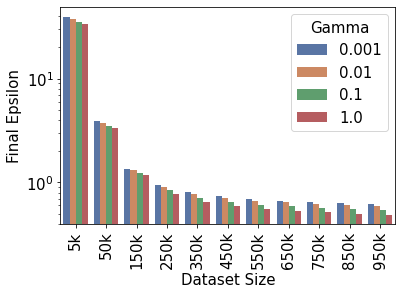

In [18]:
g = sns.barplot(data=df, x='Dataset Size', y='Final Epsilon', hue='Gamma',  palette='deep')
ticklabels = ['5k', '50k', '150k', '250k', '350k', '450k', '550k', '650k', '750k', '850k', '950k']
# g.set_xticks(sizes)
g.set_xticklabels(ticklabels, rotation=90)
g.set(yscale='log')
# plt.ylim(-1, 4)
plt.savefig('Plots/LTvsMA/varying_gamma.png',bbox_inches="tight",dpi=300)
plt.show()

In [19]:
noise =  4
iterations = 10000
batch_size = 250

In [ ]:
sizes = np.arange(5000, 1000000, 20000)
gamma = 1
ds = []
eps = []
for s in sizes:
    target_delta = 10**-(len(str(s))+1)
    lt_eps = compute_epsilon(noise, batch_size,iterations, target_delta, s, gamma)
    
    ma_eps = epsilon(s, batch_size, noise, 1*iterations, target_delta)
    
    c = 1
    while(ma_eps<lt_eps):
        c += 1
        ma_eps = epsilon(s, batch_size, noise, c*iterations, target_delta)
    ds.append(c)
    eps.append(lt_eps)

In [ ]:
plt.plot(sizes, ds)
ticklabels = ['5k', '50k', '150k', '250k', '350k', '450k', '550k', '650k', '750k', '850k', '950k']
plt.xticks(np.append([5000],np.arange(50000, 1000000, 100000)), ticklabels, rotation=90)
# plt.xticks(sizes, rotation=90)
plt.ylabel('#Candidates')
plt.xlabel('Dataset size')
plt.savefig('Plots/LTvsMA/candvssize.png', bbox_inches="tight",dpi=300)